# Mount Google Drive

In [ ]:
#Your google drive is made accesible to Colab.
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/TESIS_AI_PABLO/Codes_data_paper_symmetries/
    %ls -lht
    # To import own packages set local path in packages syspath
    import sys
    sys.path.insert(0,"./")
except ImportError:
    print("You are not in google.colab!!")
    pass

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/TESIS_AI_PABLO/Codes_data_paper_symmetries
total 345K
-rw------- 1 root root 202K Jul 13 13:17  symmetry_seeker_neural_network.ipynb
drwx------ 2 root root 4.0K Jul  5 15:46  models_3root/
drwx------ 2 root root 4.0K Jul  5 15:43  models_3root_pablo_/
-rw------- 1 root root 2.5K Jul  5 15:41  plot_delta_loss_vs_M.py
-rw------- 1 root root 6.2K Jul  5 15:26  calculate_group_metrics.py
-rw------- 1 root root  13K Jul  5 15:26  subroutines.py
-rw------- 1 root root  78K Jul  4 19:01 'explicación carpeta códigos + datos paper simetrías.pdf'
drwx------ 2 root root 4.0K Jul  4 16:35  data/
drwx------ 2 root root 4.0K Jul  4 16:29  __pycache__/
-rw------- 1 root root 8.1K Jul  4 16:29  main_SSNN_dynamic_M.py
drwx------ 2 root root 4.0K Jul  4 14:47  models_tetrahedron/
drwx------ 2 root root 4.0K Jul  4 14:47  models_square/
drwx------ 2 roo

# Main imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2

#holaholaa

# Define Symmetric Seeker Neural Network $\rightarrow$ SymSeekerNN class

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.engine import compile_utils

class SymSeekerNN(tf.keras.Model):
    '''
    Description
    '''
    def __init__(self,Nfeatures,Nbranches,
                 input_layer=None,
                 standard_layers=None,
                 branches_output=None,
                 model_saved=None):
        super(SymSeekerNN, self).__init__()

        self.Nfeatures=Nfeatures
        self.Nbranches=Nbranches
        #try... except
        if(model_saved!=None):
          self.model=model_saved
        else:
          self.input_layer=input_layer
          self.standard_layers=standard_layers
          # Latent layer
          self.latent_layer = standard_layers.layers[-1]
          self.latent_layer.units=(self.Nfeatures)
          # Branches
          self.branches_output = branches_output
          self.branches_output.units=int(self.Nfeatures*self.Nbranches)
          self.branches_output.use_bias= False
          self.branches_output.activation=None
          self.model=Sequential([self.input_layer,
                                self.standard_layers,
                                self.branches_output])

    @classmethod
    def load_model(cls, path,Nfeatures,Nbranches):
        model_saved=models.load_model(path,compile=False)
        # Create an instance of the custom model class using the provided config
        model = cls(Nfeatures,Nbranches,model_saved=model_saved)
        # Perform any additional customizations if required
        return model

    def call(self, inputs):
        # The usual forward pass of the model
        return self.model(inputs)

    def get_config(self):
        config = super(SymSeekerNN, self).get_config()
        # Add any custom configurations to the config dictionary
        custom_methods = {
            'summary' : self.summary.__name__,
            'symmetry_loss_Nb'  : self.symmetry_loss_Nb.__name__,
            'calculate_d_closed': self.calculate_d_closed.__name__,
            'calculate_d_inv'   : self.calculate_d_inv.__name__,
            'obtain_list_branch_matrices_ref' : self.obtain_list_branch_matrices_ref.__name__,
            '_list_acting_branches' : self._list_acting_branches.__name__,
            'activity_single_branch' : self.activity_single_branch.__name__,
            'list_activities' : self.list_activities.__name__
        }
        config['custom_methods'] = custom_methods
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance of the custom model class using the provided config
        model = cls()
        # Perform any additional customizations if required
        return model

    def summary(self):
       return self.model.summary()

    def evaluate_loss(self,x_true,x_pred):
       return self.loss(x_true,x_pred)

    def compile(self, optimizer='adam',**kwargs):
        super(SymSeekerNN, self).compile(**kwargs)
        self.optimizer= optimizer
        # Uses symmetry_loss_Nb
        self.loss=self.symmetry_loss_Nb(self.Nbranches,self.Nfeatures)
        loss_weights=None
        self.output_names = None
        self.model.compile(loss=self.loss)
        self.compiled_loss = compile_utils.LossesContainer(
          self.loss, loss_weights, output_names=self.output_names)

    def symmetry_loss_Nb(self,Nbranches,Nfeatures):
      '''
      description
      '''
      def NBsym_loss(x_true,x_pred):

          mbs = tf.shape(x_pred)[0]

          x_true = tf.cast(x_true, dtype = 'float32')
          x_pred = tf.cast(x_pred, dtype = 'float32')

          diff_squared = (x_pred-x_true)*(x_pred-x_true)
          sum_kernel = tf.constant(np.ones((1,Nfeatures)),tf.float32)
          cost_matrix = tf.nn.conv2d(tf.reshape(diff_squared,(1,mbs,int(Nfeatures*Nbranches),1)),tf.reshape(sum_kernel,(1,Nfeatures,1,1)),strides=[1,Nfeatures],padding='VALID')
          cost_matrix = tf.reshape(cost_matrix,(mbs,Nbranches))

          cost_matrix = 0.5*cost_matrix
          cost_vector = tf.math.reduce_min(cost_matrix, axis=1)
          mbs = tf.cast(mbs, dtype = 'float32')
          loss = tf.math.reduce_sum(cost_vector)/mbs
          return loss
      return NBsym_loss

    def obtain_list_branch_matrices_ref(self,index_reference):
      '''
      index_reference goes from 0 to Nbranches-1
      '''
      w = self.model.get_weights()
      w_ref_inv = np.linalg.inv(w[-1][0:self.Nfeatures,index_reference*self.Nfeatures:(index_reference+1)*self.Nfeatures])
      list_mats = []
      for branch in range(self.Nbranches):
          real_branch = w[-1][0:self.Nfeatures,branch*self.Nfeatures:(branch+1)*self.Nfeatures]
          list_mats.append( np.matmul(w_ref_inv,real_branch) )
      return list_mats

    def calculate_d_closed(self,index_reference):
      list_mats=self.obtain_list_branch_matrices_ref(index_reference)
      sum = 0.0
      for alpha in list_mats:
          for beta in list_mats:
              Wab = np.matmul(alpha,beta)
              min = 100000000000000.0
              for gamma in list_mats:
                  Wab_Wg = Wab - gamma
                  loss = np.sum( np.absolute( Wab_Wg ) )
                  if(loss<min):
                      min = loss
              sum = sum + min
      d_closed = sum/(self.Nfeatures*self.Nfeatures*self.Nbranches*self.Nbranches)
      return d_closed

    def calculate_d_inv(self,index_reference):
      '''
      Eq. XX in Calvo-Barlés et al. ....
      '''
      list_mats=self.obtain_list_branch_matrices_ref(index_reference)
      sum2 = 0.0
      for alpha in list_mats:
          Wa_inv = np.linalg.inv(alpha)
          min2 = 100000000000000.0
          for gamma in list_mats:
              Wa_inv_Wg = Wa_inv - gamma
              loss2 = np.sum( np.absolute (Wa_inv_Wg ) )
              if(loss2 < min2):
                  min2=loss2
          sum2 = sum2 + min2
      d_inv = sum2/(self.Nfeatures*self.Nfeatures*self.Nbranches)
      return d_inv

    def _list_acting_branches(self,x_true,x_pred):
        '''
        Returns a list of size ntrain that gives the branch index with the minimum MSE
        '''
        ndata = np.shape(x_true)[0]

        cost_matrix = (x_pred[:,0]-x_true[:,0])*(x_pred[:,0]-x_true[:,0])
        for j in range(1,self.Nfeatures):
            cost_matrix = cost_matrix + (x_pred[:,j]-x_true[:,j])*(x_pred[:,j]-x_true[:,j])

        for i in range(1,self.Nbranches):
            cost_column = (x_pred[:,self.Nfeatures*i]-x_true[:,0])*(x_pred[:,self.Nfeatures*i]-x_true[:,0])
            for j in range(1,self.Nfeatures):
                cost_column = cost_column + (x_pred[:,self.Nfeatures*i+j]-x_true[:,j])*(x_pred[:,self.Nfeatures*i+j]-x_true[:,j])

            cost_matrix = np.concatenate((cost_matrix,cost_column), axis = 0)

        cost_matrix = np.reshape(cost_matrix,(self.Nbranches,ndata))
        cost_matrix = np.transpose(cost_matrix)
        cost_matrix = 0.5*cost_matrix
        return np.argmin(cost_matrix,axis=1)

    def activity_single_branch(self,branch_to_evaluate,x_true,x_pred):
        '''
        Returns the activity of the branch with index "branch_to_evaluate"
        '''
        ntrain = np.shape(x_true)[0]
        ##### CALCULATE column_mins #####
        column_mins = self._list_acting_branches(x_true,x_pred)
        column_mins = list(column_mins)
        ##### CALCULATE list_counter #####
        list_percentage = []
        for i in range(self.Nbranches):
            list_percentage.append((column_mins.count(i)*100)/ntrain)
        return list_percentage[branch_to_evaluate]

    def list_activities(self,x_true,x_pred):
        '''
        Returns the list of activities of all the branches
        '''
        ntrain = np.shape(x_true)[0]
        ##### CALCULATE column_mins #####
        column_mins = self._list_acting_branches(x_true,x_pred)
        column_mins = list(column_mins)
        ##### CALCULATE list_counter #####
        list_percentage = []
        for i in range(self.Nbranches):
            list_percentage.append((column_mins.count(i)*100)/ntrain)
        return list_percentage

## SymSeekNN Class information

In [ ]:
# Class class information
print(SymSeekerNN.__doc__)

# Methods available
method_list = [method for method in dir(SymSeekerNN) if method.startswith('__') is False]
print("Methods defined for class ",SymSeekerNN.__name__)

for method in method_list:
  print(method)
print('\n')

# Description of the method (if available)
# From the list below write print(SymSeekerNN.name_of_the_method.__doc__)
# For example
print("Method=",SymSeekerNN.symmetry_loss_Nb.__name__)
print(SymSeekerNN.symmetry_loss_Nb.__doc__)


    Description
    
Methods defined for class  SymSeekerNN
_SCALAR_UPRANKING_ON
_TF_MODULE_IGNORED_PROPERTIES
_add_trackable
_add_trackable_child
_add_variable_with_custom_getter
_assert_compile_was_called
_assert_weights_created
_autographed_call
_cast_single_input
_check_call_args
_check_sample_weight_warning
_checkpoint_dependencies
_clear_losses
_compile_was_called
_compute_dtype
_configure_steps_per_execution
_dedup_weights
_deferred_dependencies
_delete_tracking
_deserialization_dependencies
_deserialize_from_proto
_dtype
_eager_losses
_expects_mask_arg
_expects_training_arg
_export_to_saved_model_graph
_flatten
_flatten_layers
_flatten_modules
_functional_construction_call
_gather_children_attribute
_gather_saveables_for_checkpoint
_get_callback_model
_get_cell_name
_get_compile_args
_get_existing_metric
_get_input_masks
_get_node_attribute_at_index
_get_optimizer
_get_save_spec
_get_trainable_state
_get_unnested_name_scope
_handle_activity_regularization
_handle_deferred_depe

# Calculate the data

In [ ]:
def z_power_n(x,y,n):
    z = x + 1j*y
    w = z**n
    return np.real(w),np.imag(w)

Nsamples = 20000 #Number of samples for training/validation data
L = 10.0
n = 3
problem_name = str(n)+'root'

# GENERATE DATA
x = [] #Physical features
y = [] #Measurable magnitudes

for i in range(Nsamples):
    #print('Sample #',i)
    #polar coordinates
    rho = np.random.uniform(0,L)
    phi = np.random.uniform(0,2*np.pi) #np.random.normal(np.pi/2, np.pi/4) (gaussian)
    xx = rho*np.cos(phi); yy = rho*np.sin(phi)
    single_x = [xx,yy]
    single_y = z_power_n(xx,yy,n)
    x.append(single_x)
    y.append(single_y)
x = np.array(x)  # w
y = np.array(y)  # z^n

# Read the data (¿Se dará una database para probar?)

In [ ]:
#@title
def read_data(fileX, filey):
    X = pd.read_csv(fileX, header = None)
    X = np.array(X)
    y = pd.read_csv(filey, header = None)
    y = np.array(y)
    return X, y

filex = './data/X_3root.csv'
filey = './data/Y_3root.csv'
x,y = read_data(filex,filey)

# Define tranining and validation dataset

In [ ]:
ntrain = int(0.95*Nsamples)
nvalidation = Nsamples-ntrain

Nfeatures = y.shape[1]
L = 10.0
n = 3
x = x/L
y = y/(L**n)
problem_name = str(n)+'root'

xtr_single = x[0:ntrain,:]
xva_single = x[ntrain:ntrain + nvalidation, :]
ytr = y[0:ntrain,:]
yva = y[ntrain:ntrain + nvalidation, :]

print(xtr_single.shape,xva_single.shape)

(19000, 2) (1000, 2)


# Run the SNNN network

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 162       
                                                                 
 dense_7 (Dense)             (None, 6)                 12        
                                                                 
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
149/149 [==============================] - 3s 7ms/step - loss: 0.1001 - val_loss: 0.0712
Epoch 2/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.0598 - val_loss: 0.0502
Epoch 3/1000
149/149 [==============================] - 2s 10ms/step - loss: 0.0351 - val_loss: 0.0226
Epoch 4/1000
149/149 [==============================] - 1s 7ms/step - loss: 0.0192 - val_loss: 0.0170
Epoch 5/1000
149/149 [=====================

<function matplotlib.pyplot.show(close=None, block=None)>

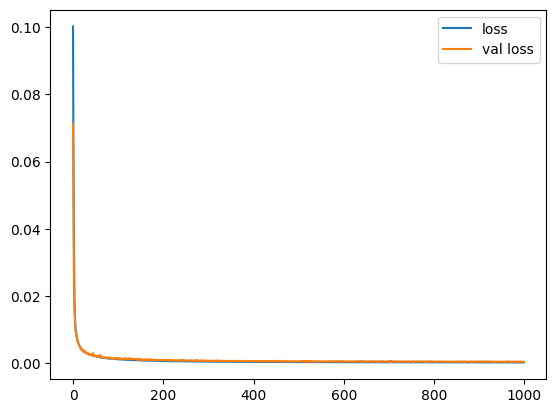

In [ ]:
epochs = 1000
minib_size = 128
eta = 0.01
Nbranches = 3 #The training process starts with a NN with "max_Nbranches" branches

# Save the models
directory = './models_'+str(problem_name)+'/'

# 0) EXPAND TRAINING OUTPUTS
#ytr = np.tile(ytr_single,reps=(1,Nbranches))
#yva = np.tile(yva_single,reps=(1,Nbranches))
#output_neurons = ytr.shape[1]

xtr = np.tile(xtr_single,reps=(1,Nbranches))
xva = np.tile(xva_single,reps=(1,Nbranches))
output_neurons = xtr.shape[1]

# 1) DEFINE THE MODEL
# Input layer
input_neurons  = ytr.shape[1]
input_layer = Input(shape=(input_neurons,))

# Standard model
nneurons = 10; nhidden = 2
standard_layers=Sequential()
hidden_layer = Dense(nneurons, activation='sigmoid' ,
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(input_neurons)),
                     bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))
standard_layers.add(hidden_layer)
for j in range(1,nhidden):
    hidden_layer = Dense(nneurons, activation='sigmoid' ,
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(nneurons)),
                         bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))
    standard_layers.add(hidden_layer)

# Latent layer
latent_layer = Dense(1,activation=None,
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(nneurons)),
                     bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1))

standard_layers.add(latent_layer)

# Branches
branches_output = Dense(1,
                        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1/np.sqrt(Nfeatures)))

model=SymSeekerNN(Nfeatures,Nbranches,
                  input_layer,
                  standard_layers,
                  branches_output)

# 3) COMPILE THE MODEL
name_opt='Adam'
opt = tf.keras.optimizers.Adam(eta)
model.compile(optimizer=opt)
model.summary()

# 3) FIT THE MODEL
r = model.fit(ytr, xtr, batch_size = minib_size, epochs=epochs,verbose=1, validation_data=(yva, xva))

# 4) SAVE THE MODEL
i=0
file_name = 'Model_'+str(i)+'sim_'+str(Nbranches)+'branches'
model.save(directory+'/'+file_name)

# 5) PLOT THE LOSS
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show

# Calculate metrics based on SymSeekerNN class

## Load the model (if previously saved in a file)

In [ ]:
n=3
problem_name = str(n)+'root'
Nfeatures=2
Nbranches=3
sim=0
path='./models_'+problem_name+'/Model_'+str(sim)+'sim_'+str(Nbranches)+'branches'
model=SymSeekerNN.load_model(path,Nfeatures,Nbranches)
model.compile(optimizer='adam')


In [ ]:
# Alternative way ...
print('path=',path)
model_saved=models.load_model(path,compile=False)
model=SymSeekerNN(Nfeatures=Nfeatures,
                  Nbranches=Nbranches,
                  model_saved=model_saved)
model.compile(optimizer='adam')

path= ./models_3root/Model_0sim_3branches


## Prediction of $x$

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 162       
                                                                 
 dense_7 (Dense)             (None, 6)                 12        
                                                                 
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________
594/594 [==============================] - 4s 7ms/step
Loss= 0.0003031304
(19000, 6) (19000, 2)
(19000, 6)
0
1
2


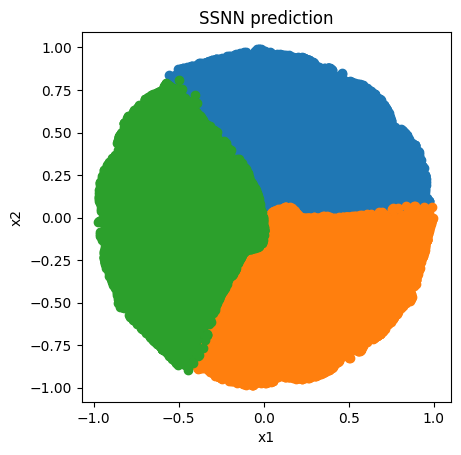

In [ ]:
import matplotlib.pyplot as plt

xtr = np.tile(xtr_single,reps=(1,Nbranches))

model.summary()
xtr_NN = model.predict(ytr)
score=model.evaluate_loss(xtr,xtr_NN)
print("Loss=",score.numpy())
print(xtr_NN.shape,ytr.shape)

true_data=False
if(true_data):
  x=xtr;Nb=1
else:
  x=xtr_NN;Nb=Nbranches

print(xtr.shape)
for i in range(Nb):
  print(i)
  # Sample data
  x1 = x[:,2*i]
  x2 = x[:,2*i+1]
  # Create a scatter plot
  plt.scatter(x1, x2)

# Set plot title and labels
plt.title('SSNN prediction')
plt.xlabel('x1')
plt.ylabel('x2')

# Set equal aspect ratio for the plot
plt.axis('square')

# Show the plot
plt.show()


## Calculate $Activity$

In [ ]:
for i in range(Nbranches):
 activity=model.activity_single_branch(i,xtr,xtr_NN)
 print("Activity=",activity)

activities=   model.list_activities(xtr,xtr_NN)
print("\n List of activities=",activities)

index_reference=np.argmax(activities)
print("\n Index of reference=",index_reference)

Activity= 33.22105263157895
Activity= 33.705263157894734
Activity= 33.07368421052632

 List of activities= [33.22105263157895, 33.705263157894734, 33.07368421052632]

 Index of reference= 1


## Calculate group metrics: $d_{closed}$ and $d_{inverse}$

In [ ]:
D_NN=model.obtain_list_branch_matrices_ref(index_reference)
#print("List mat=\n",D_NN)

# Print the array in a human-readable format
for i,arr in enumerate(D_NN):
  print("D=",i)
  np.savetxt(sys.stdout, arr, fmt='%f')

print("\n d_closed metrics=",model.calculate_d_closed(index_reference))
print(" d_inverse metrics=",model.calculate_d_inv(index_reference))

D= 0
-0.510816 0.875265
-0.871557 -0.489350
D= 1
1.000000 0.000000
-0.000000 1.000000
D= 2
-0.500721 -0.874779
0.866983 -0.507413

 d_closed metrics= 0.003408576469379396
 d_inverse metrics= 0.006588328654116775
